In [ ]:
# default_exp funcs.file_io

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# File handling

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
from tifffile import imread
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.psf import crop_psf
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.dataset import *
from torch.utils.data import DataLoader
from collections.abc import MutableSequence

In [ ]:
#export
def load_model_state(model, path):
    """
    Loads the network parameters, the intensity parameters and the scaling into model given a path.
    """
    model_dict = torch.load(path)
    model.load_state_dict(model_dict['state_dict'])
    model.inp_scale = model_dict['scaling'][0]
    model.inp_offset = model_dict['scaling'][1]
    return model

In [ ]:
#export
def get_df_from_hdf5(group):
    
    df = DF()
    for k in group.keys():
        df[k] = group[k][()]
    return df

def add_df_to_hdf5(parent, name, df):
    
    g = parent.create_group(name)
    for k in df.keys():
        g.create_dataset(k, data=df[k].values)

In [ ]:
#export
def swap_psf_vol(psf, vol):
    state_dict = psf.state_dict()
    if len(vol) == 1:
        for i in range(len(state_dict['psf_volume'])):
            state_dict['psf_volume'][i] = torch.cuda.FloatTensor(torch.Tensor(vol).cuda())
    else:
        state_dict['psf_volume'] = torch.cuda.FloatTensor(torch.Tensor(vol).cuda())
    psf.load_state_dict(state_dict)
    return psf

def get_gaussian_psf(size_zyx, radii, pred_z, n_cols=1):
    
    if not pred_z:
        size_zyx[0] = 1
        
    if not isinstance(radii, MutableSequence):
        radii = 3*[radii]
    
    psf = LinearInterpolatedPSF(size_zyx, device='cuda', n_cols=n_cols)
    gauss_vol = gaussian_sphere(size_zyx, radii, [size_zyx[0]//2,size_zyx[1]//2,size_zyx[2]//2])
    gauss_vol = gauss_vol/gauss_vol.max()
    
    psf = swap_psf_vol(psf, gauss_vol)
    return psf

def get_vol_psf(filename, device='cuda', psf_extent_zyx=None, n_cols=1, fac=1.):
    
    if 'tif' in filename:
        psf_vol = load_tiff_image(filename)
        psf_vol = psf_vol/psf_vol.max()
        psf_vol = psf_vol*fac
        psf = LinearInterpolatedPSF(psf_vol.shape[-3:], device=device, n_cols=n_cols)
        psf.psf_fac = fac
        if psf_vol.ndim == 3: psf_vol = psf_vol[None]
        psf = swap_psf_vol(psf, psf_vol)
        
    else:
        psf_state = torch.load(filename)
        psf = LinearInterpolatedPSF(psf_state['psf_volume'].shape[-3:], device=device, n_cols=n_cols)
        psf.load_state_dict(psf_state)

        if psf_extent_zyx:
            psf = crop_psf(psf,psf_extent_zyx)
            
    return psf

def load_psf(cfg):

    if cfg.data_path.psf_path:
        psf = get_vol_psf(cfg.data_path.psf_path,cfg.genm.PSF.device, cfg.genm.PSF.psf_extent_zyx, cfg.genm.PSF.n_cols, cfg.genm.PSF.fac)
    else:
        psf = get_gaussian_psf(cfg.genm.PSF.psf_extent_zyx, cfg.genm.PSF.gauss_radii, cfg.genm.exp_type.pred_z, cfg.genm.PSF.n_cols)
        
    return psf

def load_psf_noise_micro(cfg):
    
    psf = load_psf(cfg)
    noise = hydra.utils.instantiate(cfg.genm.noise)
    micro = hydra.utils.instantiate(cfg.genm.microscope, psf=psf, noise=noise).cuda()

    return psf, noise, micro

def load_post_proc(cfg):
    if cfg.other.pp == 'si':
        return hydra.utils.instantiate(cfg.post_proc_si)
    if cfg.other.pp == 'isi':
        return hydra.utils.instantiate(cfg.post_proc_isi)
    
def get_dataloader(cfg):
    
    sim = True if cfg.data_path.image_path is None else False
    sl = eval(cfg.data_path.image_proc.crop_sl,{'__builtins__': None},{'s_': np.s_})

    if not sim:
        if 'override' in cfg.data_path.image_proc:
            imgs_5d = torch.cat([hydra.utils.instantiate(cfg.data_path.image_proc.override, image_path=f) for f in sorted(glob.glob(cfg.data_path.image_path))], 0)
        else:
            imgs_5d   = torch.cat([load_tiff_image(f)[None] for f in sorted(glob.glob(cfg.data_path.image_path))], 0)    
    
        imgs_5d       = torch.cat([img.permute(*cfg.data_path.image_proc.swap_dim)[sl][None] for img in imgs_5d], 0) 
        roi_masks     = [get_roi_mask(img, tuple(cfg.sim.roi_mask.pool_size), percentile= cfg.sim.roi_mask.percentile) for img in imgs_5d]
    else:
        imgs_5d       = torch.cat([torch.empty(list(cfg.data_path.image_shape))], 0) 
        roi_masks     = None
        gen_bg        = [hydra.utils.instantiate(cfg.sim.bg_estimation.uniform)]
        dataset_tfms  = []
        
    min_shape = tuple(np.stack([v.shape for v in imgs_5d]).min(0)[-3:])
    crop_zyx = (cfg.sim.random_crop.crop_sz, cfg.sim.random_crop.crop_sz,cfg.sim.random_crop.crop_sz)
    if crop_zyx > min_shape:
        crop_zyx = tuple(np.stack([min_shape, crop_zyx]).min(0))
        print('Crop size larger than volume in at least one dimension. Crop size changed to', crop_zyx)
        
    if not sim:
        gen_bg        = [hydra.utils.instantiate(cfg.sim.bg_estimation.smoothing, z_size=crop_zyx[0])]
        rand_crop = RandomCrop3D(crop_zyx, roi_masks)
        dataset_tfms  = [rand_crop]
    
    if cfg.sim.bg_estimation.fractal.scale:
        gen_bg.append(hydra.utils.instantiate(cfg.sim.bg_estimation.fractal))

    probmap_generator = UniformValue(cfg.genm.prob_generator.low, cfg.genm.prob_generator.high)
    rate_tfms = [probmap_generator]
    
    if cfg.genm.foci.n_foci_avg > 0:
        rate_tfms.append(hydra.utils.instantiate(cfg.genm.foci))

    ds = DecodeDataset(volumes = imgs_5d,
                       dataset_tfms =  dataset_tfms, 
                       rate_tfms = rate_tfms, 
                       bg_tfms = gen_bg, 
                       device='cuda:0', 
                       num_iter=(cfg.training.num_iters) * cfg.training.bs) 

    decode_dl = DataLoader(ds, batch_size=cfg.training.bs, num_workers=0)
    
    return imgs_5d, decode_dl
    
def load_all(cfg, load_ds=True):
    
    path = Path(cfg.output.save_dir)
    model = hydra.utils.instantiate(cfg.network)
    model = load_model_state(model, path/'model.pkl')
    post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
    _, noise, micro = load_psf_noise_micro(cfg)
    micro.load_state_dict(torch.load(path/'microscope.pkl'), strict=False)
    if load_ds:
        imgs_5d, decode_dl = get_dataloader(cfg)
    else:
        imgs_5d, decode_dl = None, None
    
    return model, post_proc, micro, imgs_5d, decode_dl

In [ ]:
cfg = OmegaConf.load('../config/experiment/MERFISH_ci_2d_sl21.yaml')
# cfg = OmegaConf.load(default_conf)
psf = load_psf(cfg)
# psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

In [ ]:
# cfg.data_path.image_path = None
# cfg.data_path.image_shape = [16,1,48,48]

In [ ]:
imgs_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [ ]:
# from decode_fish.funcs.plotting import *
# plot_3d_projections(psf.psf_volume[0])

In [ ]:
for i in range(5):
    x, local_rate, background = next(iter(decode_dl))

NameError: name 'decode_dl' is not defined

In [ ]:
size_zyx = [1,21,21]

vol_3d = []
facs = np.linspace(0.5,1.7,11)
for i in range(len(facs)):
    
    s = gaussian_sphere(size_zyx, [1.7,1.7*facs[i],1.7*facs[i]], [size_zyx[0]//2,size_zyx[1]//2,size_zyx[2]//2])
    vol_3d.append(s)
    
vol_3d = np.concatenate(vol_3d,0)
vol_3d /= vol_3d.max()

In [ ]:
from decode_fish.funcs.plotting import plot_3d_projections

(<Figure size 701.486x658.286 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

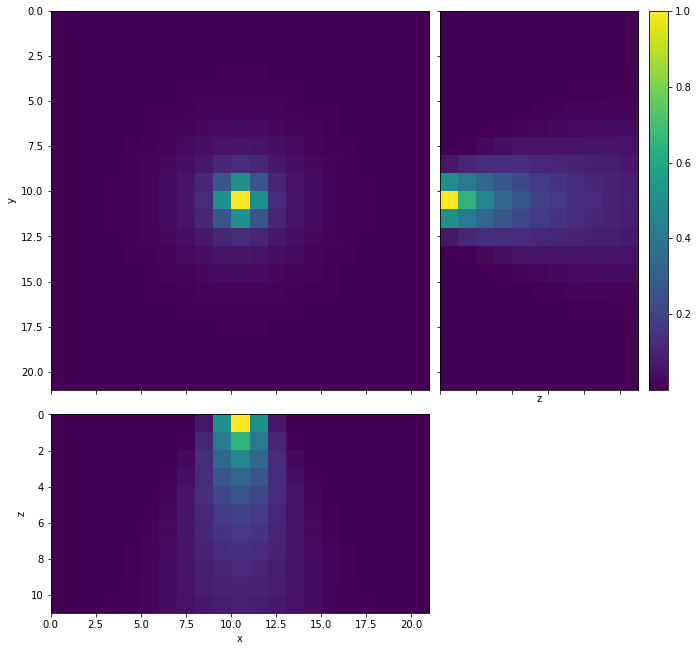

In [ ]:
plot_3d_projections(vol_3d)

In [ ]:
import tifffile
tifffile.imsave('../figures/MFsf_psf1.tif', data=vol_3d)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted index.ipynb.
